# Sequence-to-Sequence Model with Attention for English-French Translation



In [1]:
import itertools
from collections import Counter
from functools import partial
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from nltk import wordpunct_tokenize
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence
from tqdm import tqdm_notebook, tqdm
from preprocessing_task_2 import prepare_data
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from torch.utils.data import DataLoader


In [2]:
#device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device = torch.device('cpu')

device

device(type='cpu')

In [24]:
def tokenize(text, character_flag=False):
    """Turn text into discrete tokens.

    Remove tokens that are not words.
    """
    text = str(text).lower()
    if character_flag:
        tokens =[char for char in text if char.isalpha()]

    else:   
        tokens = wordpunct_tokenize(text)
        tokens = [token for token in tokens if all(char.isalpha() for char in token)]

    return tokens


class EnglishFrenchTranslations(Dataset):
    #def __init__(self, path, max_vocab):
    def __init__(self, df, max_vocab, character_flag= False):
    
        self.max_vocab = max_vocab
        self.character_flag = character_flag
        
        # Extra tokens to add
        self.padding_token = '<PAD>'
        self.start_of_sequence_token = '<SOS>'
        self.end_of_sequence_token = '<EOS>'
        self.unknown_word_token = '<UNK>'
        
        # Helper function
        self.flatten = lambda x: [sublst for lst in x for sublst in lst]
        
        # Tokenize inputs (English) and targets (French)
        self.tokenize_df(df,character_flag)

        # To reduce computational complexity, replace rare words with <UNK>
        self.replace_rare_tokens(df)
        
        # Prepare variables with mappings of tokens to indices
        self.create_token2idx(df)
        
        # Remove sequences with mostly <UNK>
        df = self.remove_mostly_unk(df)
        
        # Every sequence (input and target) should start with <SOS>
        # and end with <EOS>
        self.add_start_and_end_to_tokens(df)
        
        # Convert tokens to indices
        self.tokens_to_indices(df)
        
    def __getitem__(self, idx):
        """Return example at index idx."""
        return self.indices_pairs[idx][0], self.indices_pairs[idx][1]
    
    def tokenize_df(self, df, character_flag):
        """Turn inputs and targets into tokens."""
        df['tokens_inputs'] = df.english.apply(lambda x: tokenize(x, character_flag))
        df['tokens_targets'] = df.french.apply(lambda x: tokenize(x, character_flag))
        
    def replace_rare_tokens(self, df):
        """Replace rare tokens with <UNK>."""
        common_tokens_inputs = self.get_most_common_tokens(
            df.tokens_inputs.tolist(),
        )
        common_tokens_targets = self.get_most_common_tokens(
            df.tokens_targets.tolist(),
        )
        
        df.loc[:, 'tokens_inputs'] = df.tokens_inputs.apply(
            lambda tokens: [token if token in common_tokens_inputs 
                            else self.unknown_word_token for token in tokens]
        )
        df.loc[:, 'tokens_targets'] = df.tokens_targets.apply(
            lambda tokens: [token if token in common_tokens_targets
                            else self.unknown_word_token for token in tokens]
        )

    def get_most_common_tokens(self, tokens_series):
        """Return the max_vocab most common tokens."""
        all_tokens = self.flatten(tokens_series)
        # Substract 4 for <PAD>, <SOS>, <EOS>, and <UNK>
        common_tokens = set(list(zip(*Counter(all_tokens).most_common(
            self.max_vocab - 4)))[0])
        return common_tokens

    def remove_mostly_unk(self, df, threshold=0.99):
        """Remove sequences with mostly <UNK>."""
        def calculate_ratio(tokens):
            # Check if tokens list is empty to avoid division by zero
            if len(tokens) == 0:
                return False  #return True if to remove empty token lists
            return (sum(1 for token in tokens if token != '<UNK>') / len(tokens)) > threshold

        # Apply the function to the DataFrame columns
        df = df[df['tokens_inputs'].apply(calculate_ratio)]
        df = df[df['tokens_targets'].apply(calculate_ratio)]
        return df

    def create_token2idx(self, df):
        """Create variables with mappings from tokens to indices."""
        unique_tokens_inputs = set(self.flatten(df.tokens_inputs))
        unique_tokens_targets = set(self.flatten(df.tokens_targets))
        
        for token in reversed([
            self.padding_token,
            self.start_of_sequence_token,
            self.end_of_sequence_token,
            self.unknown_word_token,
        ]):
            if token in unique_tokens_inputs:
                unique_tokens_inputs.remove(token)
            if token in unique_tokens_targets:
                unique_tokens_targets.remove(token)
                
        unique_tokens_inputs = sorted(list(unique_tokens_inputs))
        unique_tokens_targets = sorted(list(unique_tokens_targets))

        # Add <PAD>, <SOS>, <EOS>, and <UNK> tokens
        for token in reversed([
            self.padding_token,
            self.start_of_sequence_token,
            self.end_of_sequence_token,
            self.unknown_word_token,
        ]):
            
            unique_tokens_inputs = [token] + unique_tokens_inputs
            unique_tokens_targets = [token] + unique_tokens_targets
            
        self.token2idx_inputs = {token: idx for idx, token
                                 in enumerate(unique_tokens_inputs)}
        self.idx2token_inputs = {idx: token for token, idx
                                 in self.token2idx_inputs.items()}
        
        self.token2idx_targets = {token: idx for idx, token
                                  in enumerate(unique_tokens_targets)}
        self.idx2token_targets = {idx: token for token, idx
                                  in self.token2idx_targets.items()}
        
    def add_start_and_end_to_tokens(self, df):
        """Add <SOS> and <EOS> tokens to the end of every input and output."""
        df['tokens_inputs'] = df['tokens_inputs'].apply(
            lambda tokens: [self.start_of_sequence_token] + tokens + [self.end_of_sequence_token]
        )
        df['tokens_targets'] = df['tokens_targets'].apply(
            lambda tokens: [self.start_of_sequence_token] + tokens + [self.end_of_sequence_token]
        )
        
    def tokens_to_indices(self, df):
        """Convert tokens to indices."""
        df['indices_inputs'] = df.tokens_inputs.apply(
            lambda tokens: [self.token2idx_inputs[token] for token in tokens])
        df['indices_targets'] = df.tokens_targets.apply(
            lambda tokens: [self.token2idx_targets[token] for token in tokens])
             
        self.indices_pairs = list(zip(df.indices_inputs, df.indices_targets))
        
    def __len__(self):
        return len(self.indices_pairs)

In [4]:
def read_file(file_path,fraction):
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.readlines()  # reads all lines into a list
        
    # Remove newline characters at the end of each line
    content = [line.strip() for line in content]
    
    # Calculate the number of lines to return based on the fraction
    if 0 < fraction < 1:
        end_index = int(len(content) * fraction)
        return content[:end_index]
    else:
        return content[:fraction]  # Return the full list



In [5]:
def collate(batch):
    inputs = [torch.LongTensor(item[0]) for item in batch]
    targets = [torch.LongTensor(item[1]) for item in batch]
    
    # Pad sequencse so that they are all the same length (within one minibatch)
    padded_inputs = pad_sequence(inputs, padding_value=dataset.token2idx_targets[dataset.padding_token], batch_first=True)
    padded_targets = pad_sequence(targets, padding_value=dataset.token2idx_targets[dataset.padding_token], batch_first=True)
    
    # Sort by length for CUDA optimizations
    lengths = torch.LongTensor([len(x) for x in inputs])
    lengths, permutation = lengths.sort(dim=0, descending=True)

    return padded_inputs[permutation].to(device), padded_targets[permutation].to(device), lengths.to(device)




## Seq2Seq with Attention

In [6]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, batch_size, pretrained_embeddings):
        super(Encoder, self).__init__()
        self.batch_size = batch_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.embedding.weight.data.copy_(pretrained_embeddings)  # Set pretrained weights
        self.embedding.weight.requires_grad = True  # Optionally, make embeddings trainable
        self.gru = nn.GRU(self.embedding_dim, self.hidden_size, batch_first=True)
    
    # Remaining methods remain unchanged
        
    def forward(self, inputs, lengths):
        self.batch_size = inputs.size(0)
        
        # Turn input indices into distributed embeddings
        x = self.embedding(inputs)

        # Remove padding for more efficient RNN application
        x = pack_padded_sequence(x, lengths, batch_first=True)
    
        # Apply RNN to get hidden state at all timesteps (output)
        # and hidden state of last output (self.hidden)
        output, self.hidden = self.gru(x, self.init_hidden())
        
        # Pad the sequences like they were before
        output, _ = pad_packed_sequence(output)
        
        return output, self.hidden

    def init_hidden(self):
        # Randomly initialize the weights of the RNN
        return torch.randn(1, self.batch_size, self.hidden_size).to(device)

### Define the Decoder

In [7]:
class Decoder(nn.Module):
    def __init__(
        self, 
        vocab_size,
        embedding_dim, 
        decoder_hidden_size,
        encoder_hidden_size, 
        batch_size,
        pretrained_embeddings
    ):
        super(Decoder, self).__init__()
        self.batch_size = batch_size
        self.encoder_hidden_size = encoder_hidden_size
        self.decoder_hidden_size = decoder_hidden_size
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.embedding.weight.data.copy_(pretrained_embeddings)  # Set pretrained weights
        self.embedding.weight.requires_grad = True  # Optionally, make embeddings trainable
        self.gru = nn.GRU(
            self.embedding_dim + self.encoder_hidden_size, 
            self.decoder_hidden_size,
            batch_first=True,
        )
        self.fc = nn.Linear(self.encoder_hidden_size, self.vocab_size)
        
        # Attention weights
        self.W1 = nn.Linear(self.encoder_hidden_size, self.decoder_hidden_size)
        self.W2 = nn.Linear(self.encoder_hidden_size, self.decoder_hidden_size)
        self.V = nn.Linear(self.encoder_hidden_size, 1)
    
    def forward(self, targets, hidden, encoder_output):
        self.batch_size = targets.size(0)
        
        # Switch the dimensions of sequence_length and batch_size
        encoder_output = encoder_output.permute(1, 0, 2)

        # Add an extra axis for a time dimension
        hidden_with_time_axis = hidden.permute(1, 0, 2)
        
        # Attention score (Bahdanaus)
        score = torch.tanh(self.W1(encoder_output) + self.W2(hidden_with_time_axis))

        # Attention weights
        attention_weights = torch.softmax(self.V(score), dim=1)
        
        # Find the context vectors
        context_vector = attention_weights * encoder_output
        context_vector = torch.sum(context_vector, dim=1)
        
        # Turn target indices into distributed embeddings
        x = self.embedding(targets)
        
        # Add the context representation to the target embeddings
        x = torch.cat((context_vector.unsqueeze(1), x), -1)
        
        # Apply the RNN
        output, state = self.gru(x, self.init_hidden())
        
        # Reshape the hidden states (output)
        output = output.view(-1, output.size(2))
        
        # Apply a linear layer
        x = self.fc(output)
        
        return x, state, attention_weights
    
    def init_hidden(self):
        # Randomly initialize the weights of the RNN
        return torch.randn(1, self.batch_size, self.decoder_hidden_size).to(device)

### Define a model that has both an Encoder and Decoder

In [8]:
criterion = nn.CrossEntropyLoss()

def loss_function(real, pred):
    """Calculate how wrong the model is."""
    # Use mask to only consider non-zero inputs in the loss
    mask = real.ge(1).float().to(device)
    
    loss_ = criterion(pred, real) * mask 
    return torch.mean(loss_)


class EncoderDecoder(nn.Module):
    def __init__(self, inputs_vocab_size, targets_vocab_size, hidden_size,
                 embedding_dim, batch_size, targets_start_idx, targets_stop_idx,
                 encoder_embeddings, decoder_embeddings):  # Added embeddings parameters
        super(EncoderDecoder, self).__init__()
        self.batch_size = batch_size
        self.targets_start_idx = targets_start_idx
        self.targets_stop_idx = targets_stop_idx
        
        # Pass pretrained embeddings to the encoder and decoder
        self.encoder = Encoder(inputs_vocab_size, embedding_dim,
                               hidden_size, batch_size, encoder_embeddings).to(device)
        
        self.decoder = Decoder(targets_vocab_size, embedding_dim,
                               hidden_size, hidden_size, batch_size, decoder_embeddings).to(device)
        
        
    def predict(self, inputs, lengths):
        self.batch_size = inputs.size(0)
        
        encoder_output, encoder_hidden = self.encoder(
            inputs.to(device),
            lengths,
        )
        decoder_hidden = encoder_hidden

        
        # Initialize the input of the decoder to be <SOS>
        decoder_input = torch.LongTensor(
            [[self.targets_start_idx]] * self.batch_size,
        )
        
        # Output predictions instead of loss
        output = []
        attention_matrix = [] #ADDED FOR A

        for _ in range(20): #max sequence length, since we work with short sentences
            #predictions, decoder_hidden, _ = self.decoder( 
            predictions, decoder_hidden, attention_weights = self.decoder( #ADDED FOR A
                decoder_input.to(device), 
                decoder_hidden.to(device),
                encoder_output.to(device),
                )
           
            prediction = torch.multinomial(F.softmax(predictions, dim=1), 1)
            decoder_input = prediction

            prediction = prediction.item()
            output.append(prediction)
            attention_matrix.append(attention_weights.cpu().numpy())


            if prediction == self.targets_stop_idx:
                return output,  np.stack(attention_matrix)

        return output, np.stack(attention_matrix) 

    def forward(self, inputs, targets, lengths):
        self.batch_size = inputs.size(0)
        
        encoder_output, encoder_hidden = self.encoder(
            inputs.to(device),
            #lengths,
            lengths.cpu(), #CHANGE
        )
        decoder_hidden = encoder_hidden
        
        # Initialize the input of the decoder to be <SOS>
        decoder_input = torch.LongTensor(
            [[self.targets_start_idx]] * self.batch_size,
        )
                
        # Use teacher forcing to train the model. Instead of feeding the model's
        # own predictions to itself, feed the target token at every timestep.
        # This leads to faster convergence
        loss = 0
        for timestep in range(1, targets.size(1)):
            predictions, decoder_hidden, _ = self.decoder(
                decoder_input.to(device), 
                decoder_hidden.to(device),
                encoder_output.to(device),
            )
            decoder_input = targets[:, timestep].unsqueeze(1)
            
            loss += loss_function(targets[:, timestep], predictions)
            
        return loss / targets.size(1)

In [91]:
from typing import Dict

def load_glove_embeddings(path: str, word2idx: Dict[str, int], embedding_dim: int) -> torch.Tensor:
    """
    Load GloVe embeddings from a specified file and align them with the given word index dictionary.

    Parameters:
    - path (str): The file path to the GloVe embeddings file.
    - word2idx (Dict[str, int]): A dictionary mapping words to their corresponding indices. This dictionary defines
      the position each word’s vector should occupy in the resulting embedding matrix.
    - embedding_dim (int): The dimensionality of the GloVe vectors (e.g., 50, 100, 200, 300).

    Returns:
    - torch.Tensor: A tensor of shape (len(word2idx), embedding_dim) containing the GloVe vectors aligned according to word2idx.
    """
    with open(path, 'r', encoding='utf-8') as f:
        # Initialize the embedding matrix with zeros
        #embeddings = np.zeros((len(word2idx), embedding_dim))
        #better approach: init with random 
        embeddings = np.random.uniform(-0.1, 0.1, (len(word2idx), embedding_dim))
        # Process each line in the GloVe file
        for line in f:
            values = line.split()
            word = values[0]
            
            # If the word is in the provided dictionary, update the corresponding row in embeddings
            if word in word2idx.keys():
                # Convert embedding values from strings to float32
                vector = np.asarray(values[1:], dtype='float32')
                # Place the vector in the correct index as per word2idx
                embeddings[word2idx[word]] = vector
            else:
                pass
    # Convert the numpy array to a PyTorch tensor
    return torch.from_numpy(embeddings)



def load_word2vec_embeddings(path, word2idx, embedding_dim):
    embeddings = np.random.uniform(-0.1, 0.1, (len(word2idx), embedding_dim))
    with open(path, 'r', encoding='latin1') as f:
        for line in f:
            values = line.strip().split()
            word = values[0]
            if word in word2idx:
                try:
                    vector = np.asarray(values[1:], dtype='float32')
                    embeddings[word2idx[word]] = vector
                except ValueError:
                    print(f"Error converting values for word: {word}")
                    continue
    return torch.from_numpy(embeddings)


def load_random_embeddings(word2idx: int, embedding_dim: int) -> torch.Tensor:
    """
    Create random embeddings for a specified vocabulary size and embedding dimension.

    Parameters:
    - vocab_size (int): The number of unique tokens in your vocabulary.
    - embedding_dim (int): The dimensionality of each token's vector.

    Returns:
    - torch.Tensor: A tensor of shape (vocab_size, embedding_dim) containing randomly initialized vectors.
    """
    # Initialize random embeddings in a specified range
    # range -0.1 to 0.1 is a common choice for initializing embeddings
    embeddings = np.random.uniform(-0.1, 0.1, (len(word2idx), embedding_dim))

    return torch.from_numpy(embeddings)





In [89]:

def evaluation(train_dataset,model):
    smoothing_function = SmoothingFunction().method1
    loader = DataLoader(dataset, batch_size=1, collate_fn=collate, drop_last=True)
    model.eval()
    total_loss = total = 0
    bleu_scores=[]
    with torch.no_grad():
        for inputs, targets, lengths in loader:  
            reference= ' '.join([
                dataset.idx2token_inputs[idx]
                for idx in inputs.cpu()[0].numpy()[1:-1]
            ])
            #print("english:",reference)



            target= ' '.join([
                dataset.idx2token_targets[idx]
                for idx in targets.cpu()[0].numpy()[1:-1]
            ])
            #print("french:",target)

            outputs,_ = model.predict(inputs, lengths)
            generated=(' '.join([
                dataset.idx2token_targets[idx]
                for idx in outputs[:-1]
            ]))
            bleu_score = sentence_bleu([target], generated, smoothing_function=smoothing_function)
            bleu_scores.append(bleu_score)
            #print("generated translation:",generated)

            #print()
    #print(np.mean(bleu_scores))
    return np.mean(bleu_scores)

   

In [119]:
###PREPARE DATA#########

character_flag = False
max_words = 8
fraction = 2400000
max_vocab = 2000
english_file_path = "fr-en/europarl-v7.fr-en.en"
french_file_path = "fr-en/europarl-v7.fr-en.fr"

english_data = read_file(english_file_path, fraction)
french_data = read_file(french_file_path, fraction)


filtered_english_data = []
filtered_french_data = []

for en, fr in zip(english_data, french_data):
    word_en = en.split(" ")
    word_fr = fr.split(" ")
    if len(word_en) <= max_words and len(word_fr) <= max_words:
        filtered_english_data.append(en)
        filtered_french_data.append(fr)

print("filtered_english_data:",len(filtered_english_data))


df = pd.DataFrame({
    'english': filtered_english_data,
    'french': filtered_french_data
})

dataset = EnglishFrenchTranslations(df, max_vocab, character_flag)

print("dataset:",len(dataset))
    


filtered_english_data: 145766
dataset: 71339


In [121]:
####INIT MODEL######


batch_size = 256
embedding_dim = 300
hidden_size = 1024
train_size = int(0.90 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])


train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate, drop_last=True)



# Load embeddings

vocab_en = dataset.token2idx_inputs
vocab_fr = dataset.token2idx_targets

#vocab_embeddings_en = load_word2vec_embeddings('word2vec/english.txt', vocab_en, embedding_dim)
#vocab_embeddings_fr = load_word2vec_embeddings('word2vec/france.txt', vocab_fr, embedding_dim)

#vocab_embeddings_en = load_random_embeddings( vocab_en, embedding_dim)
#vocab_embeddings_fr = load_random_embeddings( vocab_fr, embedding_dim)

vocab_embeddings_en = load_glove_embeddings('glove.6B/glove.6B.300d.txt', vocab_en, embedding_dim)
vocab_embeddings_fr = load_glove_embeddings('fasttext/cc.fr.300.vec', vocab_fr, embedding_dim)

# Create instances of Encoder and Decoder
encoder = Encoder(vocab_size=len(vocab_en), embedding_dim=embedding_dim, hidden_size=hidden_size, batch_size=batch_size, pretrained_embeddings=vocab_embeddings_en)
decoder = Decoder(vocab_size=len(vocab_fr), embedding_dim=embedding_dim, decoder_hidden_size=hidden_size, encoder_hidden_size=hidden_size, batch_size=batch_size, pretrained_embeddings=vocab_embeddings_fr)


model = EncoderDecoder(
    inputs_vocab_size=len(dataset.token2idx_inputs),
    targets_vocab_size=len(dataset.token2idx_targets),
    hidden_size=256,
    embedding_dim=embedding_dim, 
    batch_size=batch_size, 
    targets_start_idx=dataset.token2idx_targets[dataset.start_of_sequence_token],
    targets_stop_idx=dataset.token2idx_targets[dataset.end_of_sequence_token],
    encoder_embeddings=vocab_embeddings_en,  # Pass encoder embeddings
    decoder_embeddings=vocab_embeddings_fr   # Pass decoder embeddings
).to(device)

optimizer = optim.Adam([p for p in model.parameters() if p.requires_grad], lr=0.001)



In [122]:
#######TRAINING#########
save_path = "models"
model_name= "8_word_glove_big70k,"
blue_scores=[]
epochs= 20
for epoch in range(epochs):

        total_loss = total = 0
        progress_bar = tqdm_notebook(train_loader, desc='Training', leave=False)
        for inputs, targets, lengths in progress_bar:
            model.train()
            inputs, targets = inputs.to(device), targets.to(device) #CHANGE ADDED
            lengths = lengths.cpu()  #CHANGE ADDED


            # Clean old gradients
            optimizer.zero_grad()

            # Forwards pass
            loss = model(inputs, targets, lengths)

            # Perform gradient descent, backwards pass
            loss.backward()

            # Take a step in the right direction
            optimizer.step()

            # Record metrics
            total_loss += loss.item()
            total += targets.size(1)

        train_loss = total_loss / total
        
        with torch.no_grad():
            bleu_score_train = evaluation(train_dataset,model)
            bleu_score_test = evaluation(test_dataset,model)
            
        blue_scores.append([bleu_score_train,bleu_score_test])
        tqdm.write(f'epoch #{epoch + 1:3d}\ttrain_loss: {train_loss:.2e}\tBLEU: {bleu_score_test:.4f}\n')
        total_loss = total = 0
        
        path = save_path +"/"+ model_name+".pth"
        torch.save(model.state_dict(), path)


/var/folders/h3/jlbg623x4tvbrh681_7q79z80000gn/T/ipykernel_29383/2124963766.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  progress_bar = tqdm_notebook(train_loader, desc='Training', leave=False)


Training:   0%|          | 0/250 [00:00<?, ?it/s]

epoch #  1	train_loss: 1.52e-01	BLEU: 0.1725



Training:   0%|          | 0/250 [00:00<?, ?it/s]

epoch #  2	train_loss: 9.12e-02	BLEU: 0.3133



Training:   0%|          | 0/250 [00:00<?, ?it/s]

epoch #  3	train_loss: 7.03e-02	BLEU: 0.4053



Training:   0%|          | 0/250 [00:00<?, ?it/s]

epoch #  4	train_loss: 5.85e-02	BLEU: 0.4627



Training:   0%|          | 0/250 [00:00<?, ?it/s]

epoch #  5	train_loss: 5.10e-02	BLEU: 0.4959



Training:   0%|          | 0/250 [00:00<?, ?it/s]

epoch #  6	train_loss: 4.55e-02	BLEU: 0.5255



Training:   0%|          | 0/250 [00:00<?, ?it/s]

epoch #  7	train_loss: 4.13e-02	BLEU: 0.5477



Training:   0%|          | 0/250 [00:00<?, ?it/s]

epoch #  8	train_loss: 3.81e-02	BLEU: 0.5673



Training:   0%|          | 0/250 [00:00<?, ?it/s]

epoch #  9	train_loss: 3.56e-02	BLEU: 0.5813



Training:   0%|          | 0/250 [00:00<?, ?it/s]

epoch # 10	train_loss: 3.34e-02	BLEU: 0.5868



Training:   0%|          | 0/250 [00:00<?, ?it/s]

epoch # 11	train_loss: 3.14e-02	BLEU: 0.6032



Training:   0%|          | 0/250 [00:00<?, ?it/s]

epoch # 12	train_loss: 2.99e-02	BLEU: 0.6112



Training:   0%|          | 0/250 [00:00<?, ?it/s]

epoch # 13	train_loss: 2.86e-02	BLEU: 0.6164



Training:   0%|          | 0/250 [00:00<?, ?it/s]

epoch # 14	train_loss: 2.74e-02	BLEU: 0.6259



Training:   0%|          | 0/250 [00:00<?, ?it/s]

epoch # 15	train_loss: 2.60e-02	BLEU: 0.6324



Training:   0%|          | 0/250 [00:00<?, ?it/s]

epoch # 16	train_loss: 2.50e-02	BLEU: 0.6213



Training:   0%|          | 0/250 [00:00<?, ?it/s]

epoch # 17	train_loss: 2.40e-02	BLEU: 0.6384



Training:   0%|          | 0/250 [00:00<?, ?it/s]

epoch # 18	train_loss: 2.31e-02	BLEU: 0.6378



Training:   0%|          | 0/250 [00:00<?, ?it/s]

epoch # 19	train_loss: 2.21e-02	BLEU: 0.6481



Training:   0%|          | 0/250 [00:00<?, ?it/s]

epoch # 20	train_loss: 2.12e-02	BLEU: 0.6537



In [123]:
blue_scores

[[0.17441943387371855, 0.17254871960020382],
 [0.3125971053527527, 0.3132587081290175],
 [0.40581199252776884, 0.4053028486435695],
 [0.4616323144527013, 0.4627207361293617],
 [0.4961971189028195, 0.49587590056292485],
 [0.5255842045767413, 0.5255155120331326],
 [0.5467701715221363, 0.5476780824037469],
 [0.5673583807961879, 0.5673362953849321],
 [0.5814657471761812, 0.5813195760897931],
 [0.5879202594463472, 0.5868382615633305],
 [0.6039608710899919, 0.6031656127062274],
 [0.6123518798815585, 0.6111996132583619],
 [0.6170426304910149, 0.6164115409670404],
 [0.6250099820628107, 0.6259389270413734],
 [0.6319702341828851, 0.6323586602515442],
 [0.6217681321632372, 0.6213040747642967],
 [0.6406075727833632, 0.6383740856311308],
 [0.6354210221286511, 0.637840188079365],
 [0.6482796376717721, 0.648127180308443],
 [0.6533603922879471, 0.6537212870817145]]

In [65]:
def translate_text(input_text, model, dataset, device='cpu'):
    model.eval()  # Set the model to evaluation mode

    # Tokenize the input text using the same tokenizer used during training
    tokens = tokenize(input_text, translated)
    # Convert tokens to indices 
    indices = [dataset.token2idx_inputs.get(token, dataset.token2idx_inputs['<UNK>']) for token in tokens]

    # Add <SOS> and <EOS> tokens
    indices = [dataset.token2idx_inputs[dataset.start_of_sequence_token]] + indices + [dataset.token2idx_inputs[dataset.end_of_sequence_token]]
    
    # Convert list of indices to tensor
    indices_tensor = torch.LongTensor(indices).unsqueeze(0).to(device)  # Add batch dimension
    #print(len(indices_tensor))
    # Create lengths tensor
    lengths = torch.LongTensor([len(indices)]).to(device)

    # Get predictions from the model
    with torch.no_grad():
        
        outputs, attention_weights = model.predict(indices_tensor, lengths)
        #print("attention_weights",attention_weights)
        
       
    # Convert predicted indices back to words
    translation = ' '.join([dataset.idx2token_targets[idx] for idx in outputs[:-1]])
    plot_attention(attention_weights, input_text,translation)

    return translation

In [25]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_attention(attention_weights, input_sequence, output_sequence):
    input_sequence = input_sequence.split(" ")
    output_sequence = output_sequence.split(" ")
    
    #attention_weights = attention_weights[:-1]  # This slices off the last row
    #print(attention_weights)

    # Convert to numpy if it's a PyTorch tensor
    if isinstance(attention_weights, torch.Tensor):
        attention_weights = attention_weights.numpy()
    
    attention_weights = attention_weights.squeeze(-1)  
    attention_weights = attention_weights.squeeze(1)  

    # Plotting
    plt.figure(figsize=(10, 8))
    sns.heatmap(attention_weights, annot=True, cmap='viridis',
                xticklabels=input_sequence, yticklabels=output_sequence)
    plt.xlabel('Input Sequence')
    plt.ylabel('Output Sequence')
    plt.title('Attention Weights Visualization')
    plt.show()



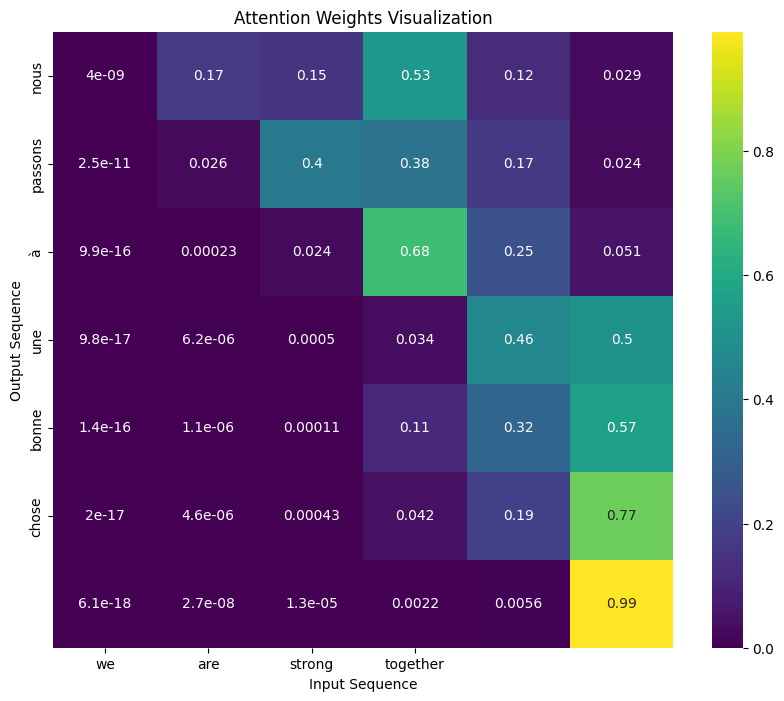

nous passons à une bonne chose


In [44]:
input_text = "we are strong together"
translated_text = translate_text(input_text, model, dataset)
print(translated_text)



In [ ]:
###########################PLOTS######################

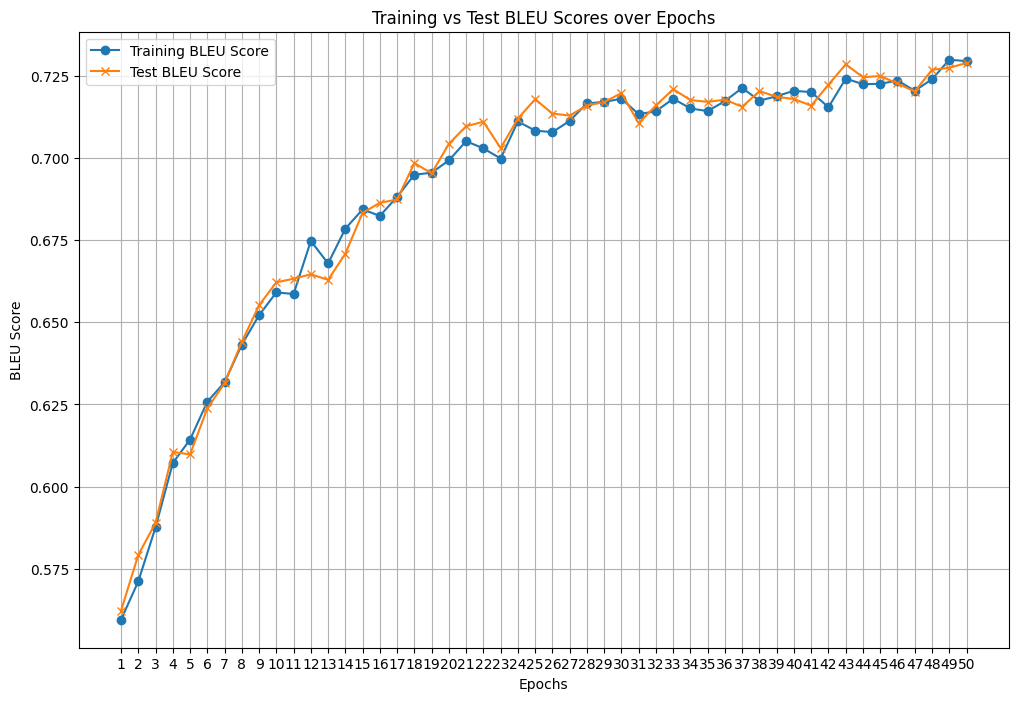

In [27]:
# train test bleu score on 20000 vocabulary and max. 5 words dataset: 36955


import matplotlib.pyplot as plt

# BLEU scores as provided
bleu_scores = [
    [0.5595212089491819, 0.5622929388968269],
    [0.5712031496820895, 0.5792430838416205],
    [0.5876512757231105, 0.5889945084532379],
    [0.6072064682692893, 0.6105657099976417],
    [0.6143299558890134, 0.6098152189437975],
    [0.6258549422625488, 0.6238184135106722],
    [0.6317539549102618, 0.6314999840674655],
    [0.6432136692159792, 0.644048471571722],
    [0.6521619100624837, 0.6552020767076827],
    [0.6591123152653712, 0.6621745504800354],
    [0.6586143506698575, 0.6632681299590796],
    [0.6747652577786573, 0.664612636582842],
    [0.6679008030245386, 0.6629257788069431],
    [0.6785084275542972, 0.6708985407201384],
    [0.6843394617783211, 0.6833054661079471],
    [0.6823878681815028, 0.6863622051534203],
    [0.6881832437913772, 0.6873679949266113],
    [0.6949145095607889, 0.698459016785417],
    [0.6955152779870626, 0.6953241826373903],
    [0.6992839624664328, 0.7043109949644775],
    [0.7051029076320573, 0.7096632443404852],
    [0.702929380206169, 0.711021315560838],
    [0.6998271557383021, 0.7030100873338755],
    [0.7111056391153273, 0.7119936249160064],
    [0.7083215652231536, 0.7178786613873543],
    [0.707870481154872, 0.7135043121709612],
    [0.7112730126874692, 0.7129041819311689],
    [0.7166029087668497, 0.7159641249225186],
    [0.7170483878898857, 0.7169910503000358],
    [0.7180239692525332, 0.7197519093529058],
    [0.7133311529043803, 0.7105871034591926],
    [0.7142081412545994, 0.7159711568426829],
    [0.7180357354498419, 0.7209440611920691],
    [0.7150574494721565, 0.7176206052943037],
    [0.7142696387243825, 0.717068802904578],
    [0.7173095985111062, 0.7177370465578562],
    [0.7213085453959027, 0.7155825708704963],
    [0.7174219823398291, 0.7203331999089765],
    [0.7188068959497196, 0.718627927021696],
    [0.7204423775137138, 0.7179324742845654],
    [0.7200390138526112, 0.7159210057006667],
    [0.7154404752199851, 0.7223282169108906],
    [0.724146683287889, 0.7284825716283828],
    [0.7224529043725181, 0.7245788631486991],
    [0.7225613542426218, 0.7249314325242697],
    [0.7235582945031424, 0.7226616701917276],
    [0.7204742395281479, 0.7201999292483793],
    [0.723933041184139, 0.7268428642983846],
    [0.7298933863666811, 0.7274244822927335],
    [0.7294707509800817, 0.7289249672413641]
]

# Separate training and test scores
epochs = list(range(1, len(bleu_scores) + 1))
train_scores = [score[0] for score in bleu_scores]
test_scores = [score[1] for score in bleu_scores]

# Create the plot
plt.figure(figsize=(12, 8))
plt.plot(epochs, train_scores, label='Training BLEU Score', marker='o')
plt.plot(epochs, test_scores, label='Test BLEU Score', marker='x')
plt.xlabel('Epochs')
plt.ylabel('BLEU Score')
plt.title('Training vs Test BLEU Scores over Epochs')
plt.xticks(epochs)  # Set x-ticks to show each epoch as an integer
plt.legend()
plt.grid(True)
plt.show()

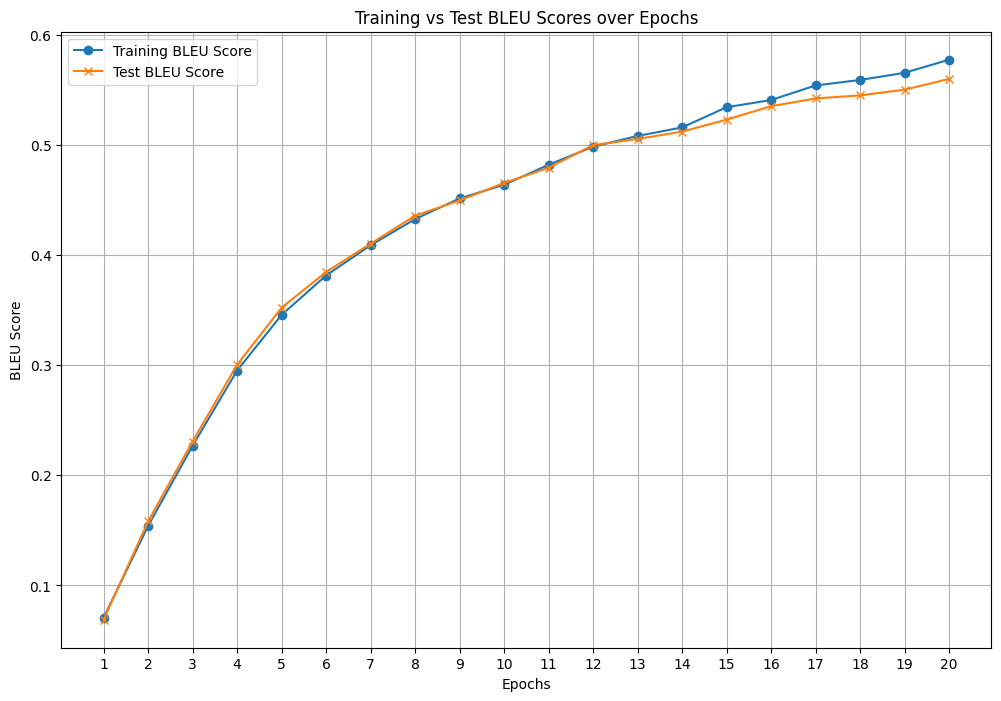

In [37]:
# train test bleu score on 20000 vocabulary and max. 8 words dataset: 41955


import matplotlib.pyplot as plt

# BLEU scores as provided
bleu_scores = [[0.0705982470338572, 0.06889766998107497],
 [0.15396208454634625, 0.1580756458911048],
 [0.22667138960834712, 0.2306217837189404],
 [0.2950220494337421, 0.30030245342771655],
 [0.34554497092389946, 0.35209609509113704],
 [0.3813353096399691, 0.38451387183935015],
 [0.40874673127637895, 0.4101861794604211],
 [0.4325403106800072, 0.4355995841764281],
 [0.4512816958926504, 0.4494625453720214],
 [0.4636525867572881, 0.46529727104912844],
[0.4818410563137742, 0.479127856622837],
 [0.498216704320132, 0.4996992952289332],
 [0.5080143881258072, 0.5052337747737582],
 [0.5157298103494931, 0.5119571775881723],
 [0.5340707503670142, 0.5227994167663339],
 [0.5405985188313663, 0.5350211517913194],
 [0.5538484016132629, 0.5420876851606323],
 [0.5588364200339918, 0.5448086745375577],
 [0.5653228863627033, 0.5500290859186354],
 [0.577217574306467, 0.5597365094878317]]



# Separate training and test scores
epochs = list(range(1, len(bleu_scores) + 1))
train_scores = [score[0] for score in bleu_scores]
test_scores = [score[1] for score in bleu_scores]

# Create the plot
plt.figure(figsize=(12, 8))
plt.plot(epochs, train_scores, label='Training BLEU Score', marker='o')
plt.plot(epochs, test_scores, label='Test BLEU Score', marker='x')
plt.xlabel('Epochs')
plt.ylabel('BLEU Score')
plt.title('Training vs Test BLEU Scores over Epochs')
plt.xticks(epochs)  # Set x-ticks to show each epoch as an integer
plt.legend()
plt.grid(True)
plt.show()




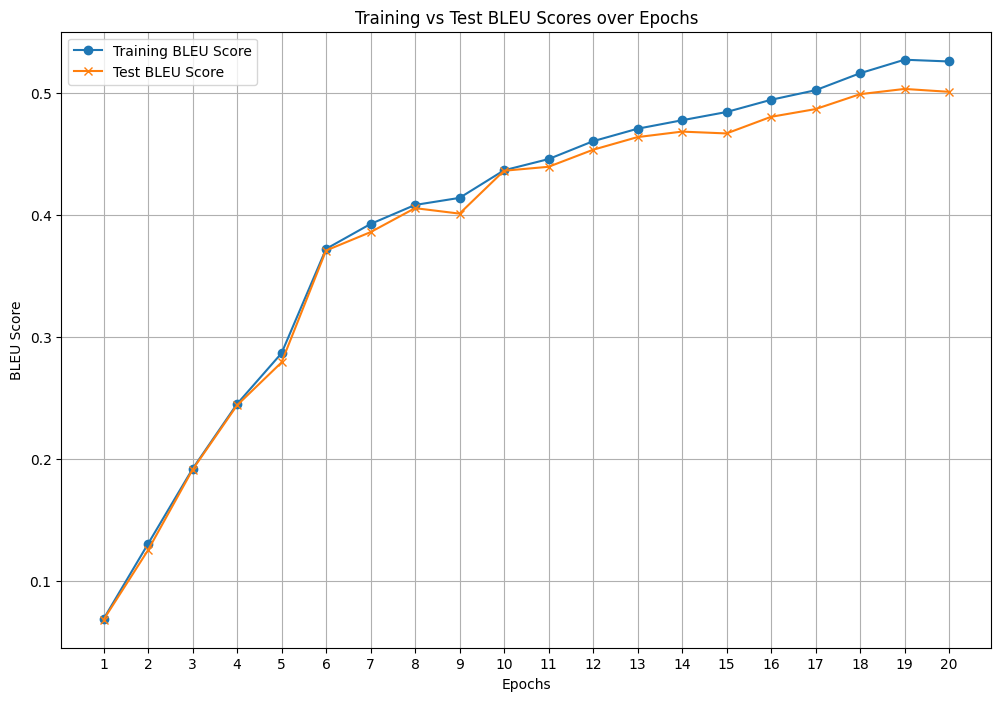

In [77]:
# train test bleu score on 20000 vocabulary and max. 11 words dataset: 41714


import matplotlib.pyplot as plt

# BLEU scores as provided
bleu_scores = [[0.06912301369967086, 0.06853373791149676],
 [0.1307173529259324, 0.12556935632641908],
 [0.19215875831328, 0.19144658006135984],
 [0.2453313885443346, 0.24424597611079737],
 [0.28692105966591824, 0.27938745726098935],
 [0.37240075370426856, 0.37107606879213173],
 [0.3928186121622996, 0.38613677165943855],
 [0.4084125854008856, 0.4057972814006256],
 [0.4142049038584932, 0.40129999131945565],
 [0.43681067663667894, 0.4364499088565725],
 [0.4459867499626655, 0.439682550609805],
 [0.460634717949837, 0.45362793160336456],
 [0.47087349479833784, 0.4640119479304262],
 [0.47780815532394016, 0.46851119857180146],
 [0.4845637866778303, 0.4670073030984121],
 [0.4945686358631201, 0.48062594094786615],
 [0.5024239743717697, 0.4869583888563314],
 [0.5163271452882942, 0.4991783109871064],
 [0.5274176517121294, 0.5034780725608794],
 [0.5259849267780835, 0.5011128425835482]]



# Separate training and test scores
epochs = list(range(1, len(bleu_scores) + 1))
train_scores = [score[0] for score in bleu_scores]
test_scores = [score[1] for score in bleu_scores]

# Create the plot
plt.figure(figsize=(12, 8))
plt.plot(epochs, train_scores, label='Training BLEU Score', marker='o')
plt.plot(epochs, test_scores, label='Test BLEU Score', marker='x')
plt.xlabel('Epochs')
plt.ylabel('BLEU Score')
plt.title('Training vs Test BLEU Scores over Epochs')
plt.xticks(epochs)  # Set x-ticks to show each epoch as an integer
plt.legend()
plt.grid(True)
plt.show()




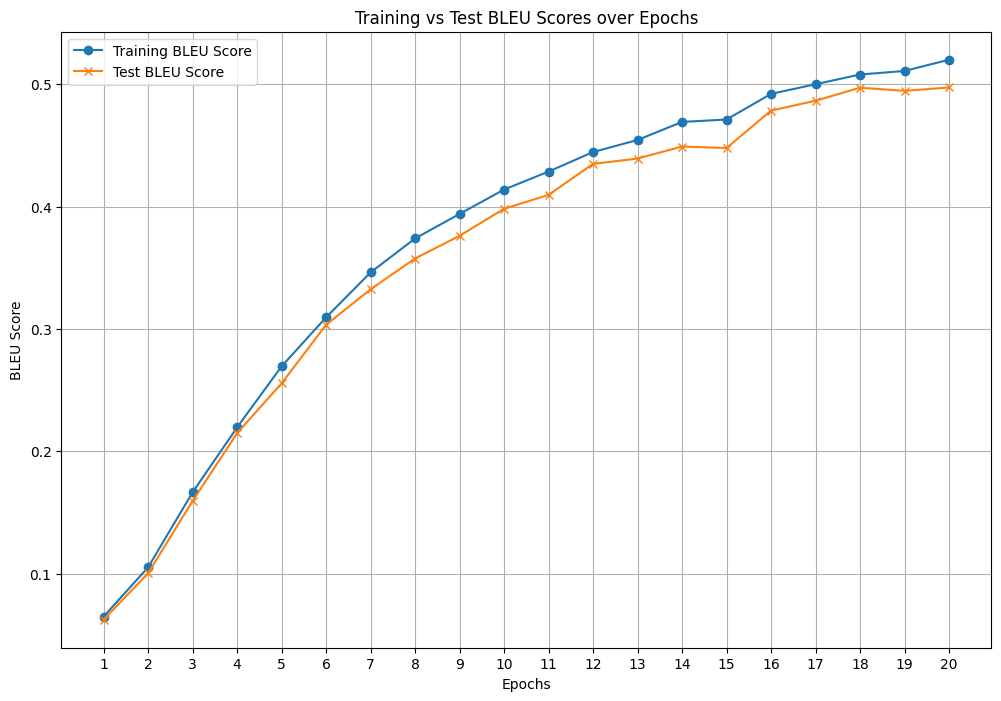

In [132]:
# train test bleu score on 20000 vocabulary and max. 8 words dataset: 41714 without pretrained embeddings


import matplotlib.pyplot as plt

# BLEU scores as provided
bleu_scores = [[0.0649407, 0.0624280],
 [0.1051783, 0.1004149],
 [0.1664576, 0.1593921],
 [0.2194972, 0.2148513],
 [0.2694005, 0.2554853],
 [0.3094308, 0.3033723],
 [0.3461544, 0.3323746],
 [0.3739011, 0.3575405],
 [0.3939536, 0.3760752],
 [0.4138640, 0.3981526],
 [0.4285630, 0.4094799],
 [0.4445328, 0.4348627],
 [0.4543711, 0.4392011],
 [0.4691274, 0.4490472],
 [0.4711125, 0.4478124],
 [0.4920446, 0.4783787],
 [0.4999544, 0.4864617],
 [0.5078798, 0.4971046],
 [0.5107724, 0.4945169],
 [0.5199629, 0.4972718]]



# Separate training and test scores
epochs = list(range(1, len(bleu_scores) + 1))
train_scores = [score[0] for score in bleu_scores]
test_scores = [score[1] for score in bleu_scores]

# Create the plot
plt.figure(figsize=(12, 8))
plt.plot(epochs, train_scores, label='Training BLEU Score', marker='o')
plt.plot(epochs, test_scores, label='Test BLEU Score', marker='x')
plt.xlabel('Epochs')
plt.ylabel('BLEU Score')
plt.title('Training vs Test BLEU Scores over Epochs')
plt.xticks(epochs)  # Set x-ticks to show each epoch as an integer
plt.legend()
plt.grid(True)
plt.show()






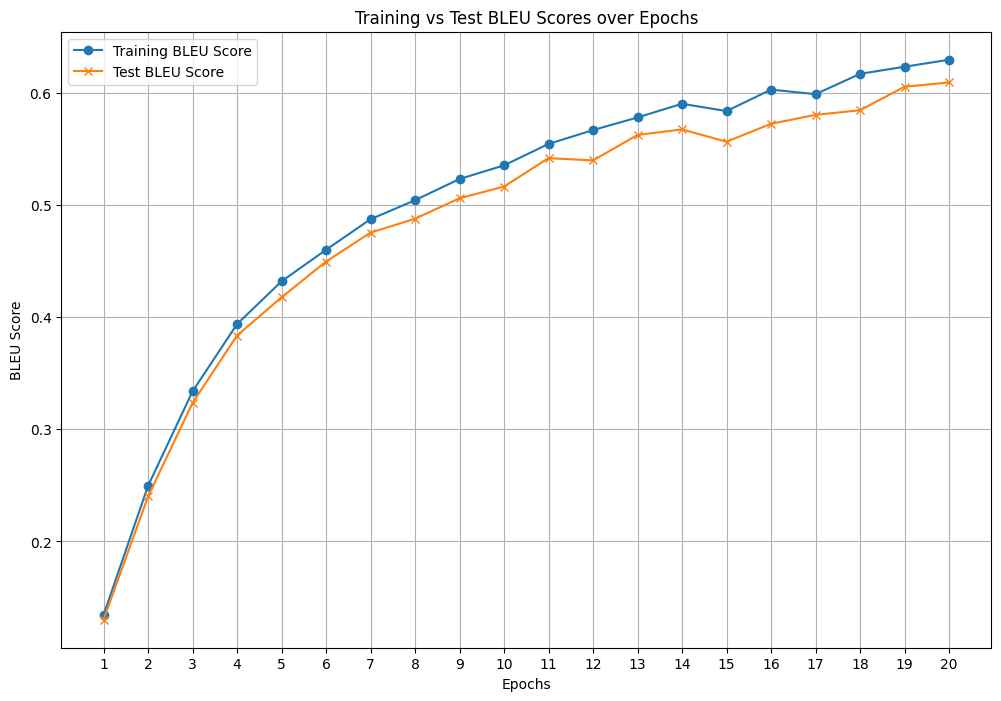

In [136]:
# train test bleu score on 20000 vocabulary and max. 8 words dataset: 41714 with glove embeddings


import matplotlib.pyplot as plt

# BLEU scores as provided
bleu_scores = [[0.1343688848600677, 0.13022863150269803],
 [0.2496096279951619, 0.24012655527715637],
 [0.3338680827236327, 0.3235414966471898],
 [0.39385484285866645, 0.38368818949073347],
 [0.43201871224411714, 0.41771056189510897],
 [0.46011923057720305, 0.44963779090125566],
 [0.4874174568635536, 0.47544100432938036],
 [0.5043413854060712, 0.4878320813363375],
 [0.5232700517966317, 0.5060585483492939],
 [0.535424898089871, 0.5165088150952416],
 [0.5545315238901877, 0.5418642911266779],
 [0.5668913001894607, 0.5398229003696385],
 [0.5781557974866331, 0.5625462069576289],
 [0.5903640070679914, 0.5674767227350405],
 [0.5838372723048056, 0.5565029209631106],
 [0.6029962342079552, 0.5724947684799992],
 [0.5988987809468549, 0.5804745731836145],
 [0.6170315429117382, 0.5845822976237743],
 [0.6233771220812048, 0.6055299298326638],
 [0.6296398799518801, 0.6093708480088683]]




# Separate training and test scores
epochs = list(range(1, len(bleu_scores) + 1))
train_scores = [score[0] for score in bleu_scores]
test_scores = [score[1] for score in bleu_scores]

# Create the plot
plt.figure(figsize=(12, 8))
plt.plot(epochs, train_scores, label='Training BLEU Score', marker='o')
plt.plot(epochs, test_scores, label='Test BLEU Score', marker='x')
plt.xlabel('Epochs')
plt.ylabel('BLEU Score')
plt.title('Training vs Test BLEU Scores over Epochs')
plt.xticks(epochs)  # Set x-ticks to show each epoch as an integer
plt.legend()
plt.grid(True)
plt.show()










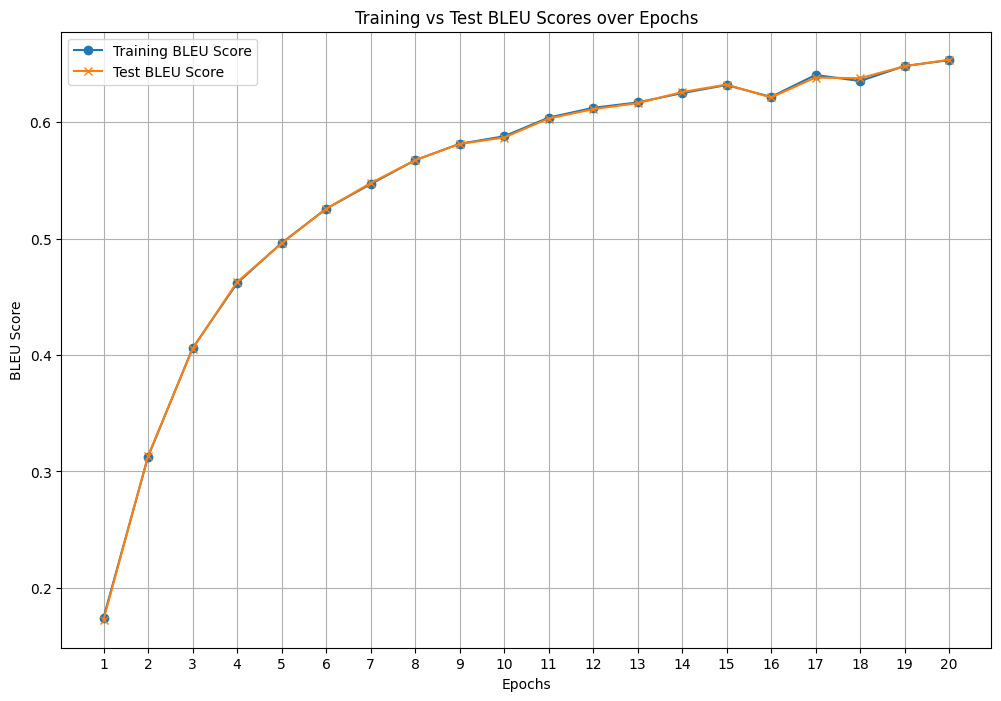

In [137]:
# train test bleu score on 20000 vocabulary and max. 8 words dataset: 72000 with glove embeddings (MAX)


import matplotlib.pyplot as plt

# BLEU scores as provided
bleu_scores =[[0.17441943387371855, 0.17254871960020382],
 [0.3125971053527527, 0.3132587081290175],
 [0.40581199252776884, 0.4053028486435695],
 [0.4616323144527013, 0.4627207361293617],
 [0.4961971189028195, 0.49587590056292485],
 [0.5255842045767413, 0.5255155120331326],
 [0.5467701715221363, 0.5476780824037469],
 [0.5673583807961879, 0.5673362953849321],
 [0.5814657471761812, 0.5813195760897931],
 [0.5879202594463472, 0.5868382615633305],
 [0.6039608710899919, 0.6031656127062274],
 [0.6123518798815585, 0.6111996132583619],
 [0.6170426304910149, 0.6164115409670404],
 [0.6250099820628107, 0.6259389270413734],
 [0.6319702341828851, 0.6323586602515442],
 [0.6217681321632372, 0.6213040747642967],
 [0.6406075727833632, 0.6383740856311308],
 [0.6354210221286511, 0.637840188079365],
 [0.6482796376717721, 0.648127180308443],
 [0.6533603922879471, 0.6537212870817145]]




# Separate training and test scores
epochs = list(range(1, len(bleu_scores) + 1))
train_scores = [score[0] for score in bleu_scores]
test_scores = [score[1] for score in bleu_scores]

# Create the plot
plt.figure(figsize=(12, 8))
plt.plot(epochs, train_scores, label='Training BLEU Score', marker='o')
plt.plot(epochs, test_scores, label='Test BLEU Score', marker='x')
plt.xlabel('Epochs')
plt.ylabel('BLEU Score')
plt.title('Training vs Test BLEU Scores over Epochs')
plt.xticks(epochs)  # Set x-ticks to show each epoch as an integer
plt.legend()
plt.grid(True)
plt.show()




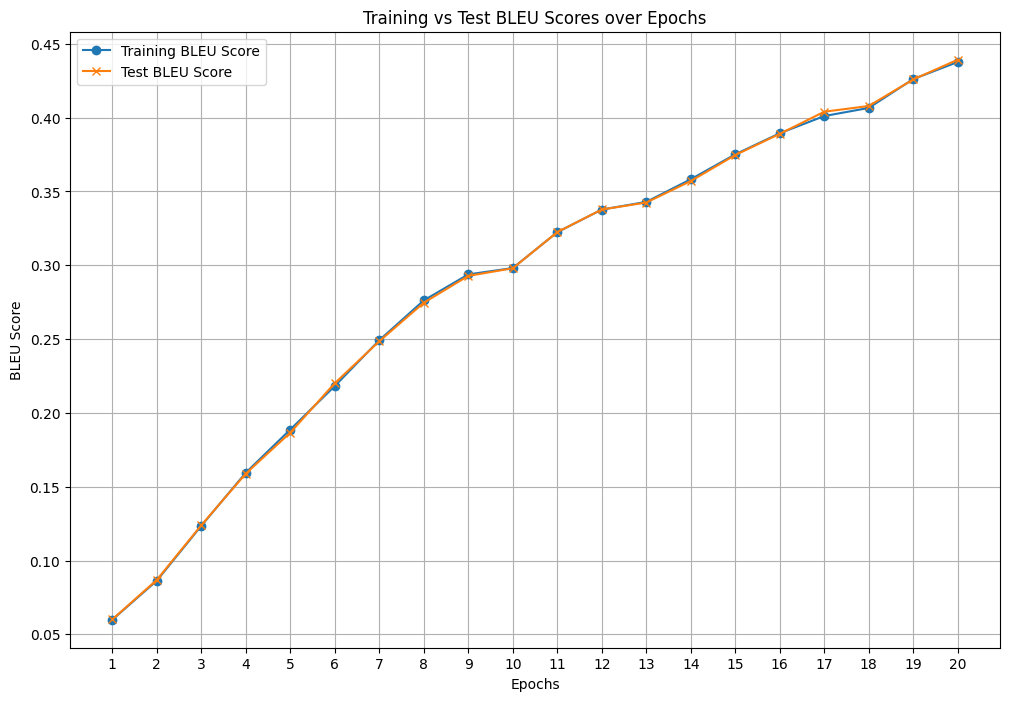

In [125]:
# train test bleu score on 8 words MAX vocabulary dataset: 42551 with glove embeddings


import matplotlib.pyplot as plt

# BLEU scores as provided
bleu_scores =[[0.05991519333424544, 0.06010842946071741],
 [0.08635177270404322, 0.08689445245570206],
 [0.12351044461010689, 0.12391922278260163],
 [0.15949834327461362, 0.15889336633875342],
 [0.1887151031032466, 0.18663811998246768],
 [0.21820407829378446, 0.22011902475606812],
 [0.24920269265627962, 0.24852794652794902],
 [0.2761869414179766, 0.2746084952603784],
 [0.29378702440744653, 0.29279816273363424],
 [0.2981020135900409, 0.29794654190855135],
 [0.3223732788712372, 0.3224321897246448],
 [0.3376967430864259, 0.33775426909703715],
 [0.34291052154625934, 0.34245966878274653],
 [0.3582195723048323, 0.3570266888144138],
 [0.37510667305739603, 0.3746194971727536],
 [0.38938689605917176, 0.3890040201393508],
 [0.40104338098288994, 0.4039689817911231],
 [0.4065378416008475, 0.40785375723056855],
 [0.4260767542090199, 0.42584543507506983],
 [0.4376592344843314, 0.43919231603875253]]



# Separate training and test scores
epochs = list(range(1, len(bleu_scores) + 1))
train_scores = [score[0] for score in bleu_scores]
test_scores = [score[1] for score in bleu_scores]

# Create the plot
plt.figure(figsize=(12, 8))
plt.plot(epochs, train_scores, label='Training BLEU Score', marker='o')
plt.plot(epochs, test_scores, label='Test BLEU Score', marker='x')
plt.xlabel('Epochs')
plt.ylabel('BLEU Score')
plt.title('Training vs Test BLEU Scores over Epochs')
plt.xticks(epochs)  # Set x-ticks to show each epoch as an integer
plt.legend()
plt.grid(True)
plt.show()

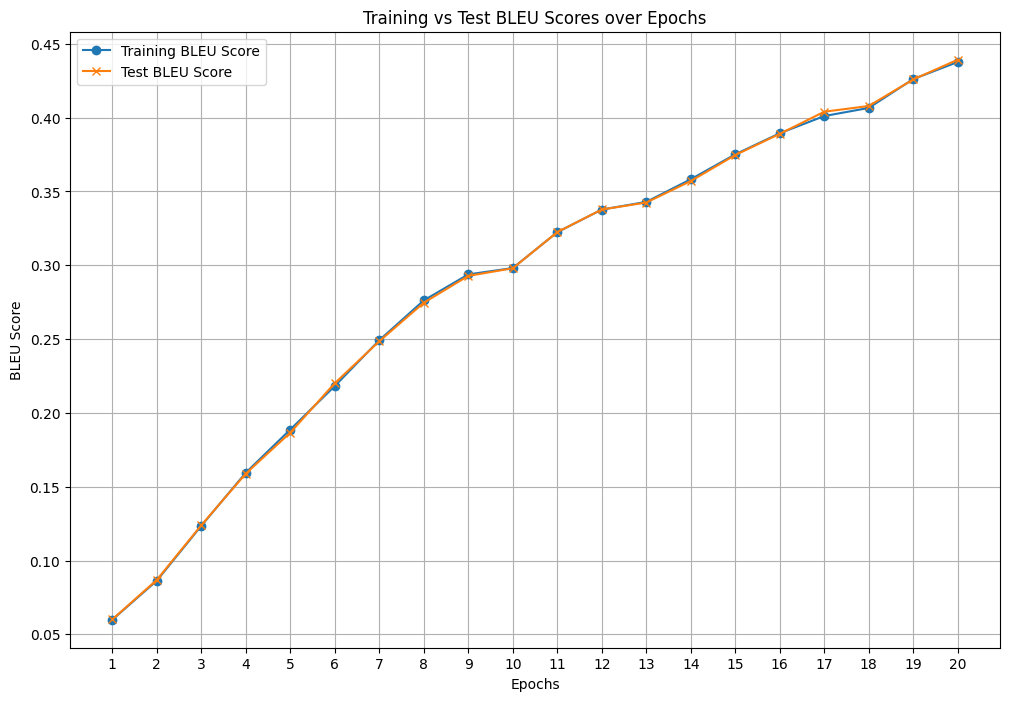

In [130]:
# train test bleu score on 2000 vocabulary and max. 5 words dataset: 42551 with word2vec embeddings CHARACTER


import matplotlib.pyplot as plt

# BLEU scores as provided
bleu_scores =[[0.05991519333424544, 0.06010842946071741],
 [0.08635177270404322, 0.08689445245570206],
 [0.12351044461010689, 0.12391922278260163],
 [0.15949834327461362, 0.15889336633875342],
 [0.1887151031032466, 0.18663811998246768],
 [0.21820407829378446, 0.22011902475606812],
 [0.24920269265627962, 0.24852794652794902],
 [0.2761869414179766, 0.2746084952603784],
 [0.29378702440744653, 0.29279816273363424],
 [0.2981020135900409, 0.29794654190855135],
 [0.3223732788712372, 0.3224321897246448],
 [0.3376967430864259, 0.33775426909703715],
 [0.34291052154625934, 0.34245966878274653],
 [0.3582195723048323, 0.3570266888144138],
 [0.37510667305739603, 0.3746194971727536],
 [0.38938689605917176, 0.3890040201393508],
 [0.40104338098288994, 0.4039689817911231],
 [0.4065378416008475, 0.40785375723056855],
 [0.4260767542090199, 0.42584543507506983],
 [0.4376592344843314, 0.43919231603875253]]



# Separate training and test scores
epochs = list(range(1, len(bleu_scores) + 1))
train_scores = [score[0] for score in bleu_scores]
test_scores = [score[1] for score in bleu_scores]

# Create the plot
plt.figure(figsize=(12, 8))
plt.plot(epochs, train_scores, label='Training BLEU Score', marker='o')
plt.plot(epochs, test_scores, label='Test BLEU Score', marker='x')
plt.xlabel('Epochs')
plt.ylabel('BLEU Score')
plt.title('Training vs Test BLEU Scores over Epochs')
plt.xticks(epochs)  # Set x-ticks to show each epoch as an integer
plt.legend()
plt.grid(True)
plt.show()





In [ ]:
################ NO ATTENTION #################

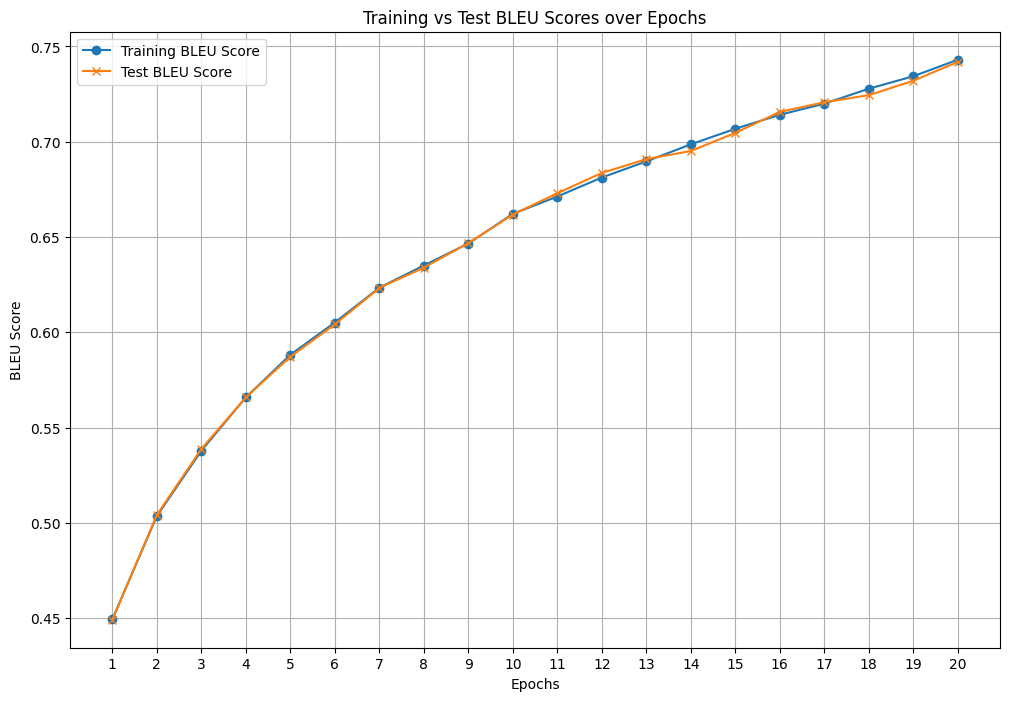

In [128]:
# no attention train test bleu score on 2000 vocabulary and max. 5 words dataset: 42551 with word2vec embeddings 


import matplotlib.pyplot as plt

# BLEU scores as provided
bleu_scores =[[0.4492841723702214, 0.4491675307847997],
 [0.5035170946804479, 0.5041359401086581],
 [0.5378002886083643, 0.5387457282871558],
 [0.5658174679673672, 0.565857628077332],
 [0.5881722609430126, 0.5871108889135552],
 [0.6051275074563796, 0.6041070874808163],
 [0.623377690863651, 0.6232517338294303],
 [0.6350316986454747, 0.6339349623177856],
 [0.6465841146694061, 0.6467555763355479],
 [0.6621276353314438, 0.6617614636400152],
 [0.6712324061244859, 0.6729727231829276],
 [0.6812045835516355, 0.6836164321970566],
 [0.6896659169421847, 0.6908447920475993],
 [0.698608564653116, 0.6951310248096675],
 [0.706775539701212, 0.7046126621646503],
 [0.7141278421236525, 0.7156418151880893],
 [0.719942548376379, 0.7207119856518823],
 [0.7278142887650979, 0.7244216801958765],
 [0.7343271630161897, 0.7319918709100128],
 [0.7430257053275946, 0.7418683597094772]]



# Separate training and test scores
epochs = list(range(1, len(bleu_scores) + 1))
train_scores = [score[0] for score in bleu_scores]
test_scores = [score[1] for score in bleu_scores]

# Create the plot
plt.figure(figsize=(12, 8))
plt.plot(epochs, train_scores, label='Training BLEU Score', marker='o')
plt.plot(epochs, test_scores, label='Test BLEU Score', marker='x')
plt.xlabel('Epochs')
plt.ylabel('BLEU Score')
plt.title('Training vs Test BLEU Scores over Epochs')
plt.xticks(epochs)  # Set x-ticks to show each epoch as an integer
plt.legend()
plt.grid(True)
plt.show()

